In [1]:
import os

project_path = '/home/xuyh/BayeFormers'

os.chdir(project_path)

In [2]:
from bayeformers import to_bayesian
from bayeformers.nn.parameters.gaussian import Gaussian


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from logging import Logger
import weightwatcher as ww
from tqdm import tqdm

from omegaconf import OmegaConf
from typing import List, Optional, Tuple
from pathlib import Path
from collections import defaultdict
import math
import wandb 

from dataclasses import dataclass
from examples.ihead.ihead_data import DataArgs, Dataset, ParallelDataLoader
from examples.ihead.ihead_basic_model import ModelArgs, Transformer

@dataclass
class OptimArgs:
    learning_rate: float = 1e-3  # for SGD
    weight_decay: float = 1e-4  # for SGD
    momentum: float = 0.9  # for SGD
    batch_size: int = 512
    use_sgd: bool = True  # otherwise use AdamW

@dataclass
class TrainerArgs:
    optim_args: OptimArgs
    data_args: DataArgs
    model_args: ModelArgs
    max_iters: Optional[int] = 10
    epoch:int=501
    pretrain:bool = True
    eval_delta: int = 5
    log_norms: bool = False
    log_probes: bool = False
    freeze_until: str = ''
    loss_head_only: bool = False
    bigram_outs_train: bool = False
    bigram_outs_test: bool = False
    num_data_workers: int = 60
    seed: int = 42
    root:Optional[str] =  "./examples/ihead/"
    load_dir: Optional[str] = ""

import powerlaw, numpy as np, matplotlib.pyplot as plt

In [3]:
args = TrainerArgs(
        optim_args=OptimArgs(),
        data_args=DataArgs(),
        model_args=ModelArgs()
    )
cfg = OmegaConf.merge(OmegaConf.structured(args))
cfg.model_args.first_ffn=True
cfg.model_args.final_ffn=True

In [4]:

torch.cuda.set_device(2)
ds = Dataset(cfg.data_args, train_test=None, bigram_outs=cfg.bigram_outs_train)
ds_test = Dataset(cfg.data_args, train_test=None, bigram_outs=cfg.bigram_outs_test)
ds_test.idxs = ds.idxs
cfg.model_args.vocab_size = ds.num_tokens
print(ds.num_tokens)
output_dim = (DataArgs.seq_length , cfg.model_args.vocab_size)

SAMPLES = 10
EPOCHS = cfg.epoch



Using fixed special tokens: [np.int64(1)] (offset 0)
Using fixed special tokens: [np.int64(1)] (offset 0)
65


In [5]:
model = Transformer(cfg.model_args)
model.cuda()

# initial param freezing
freeze_until = defaultdict(list)
to_freeze = []
if cfg.freeze_until:
    for kv in cfg.freeze_until.split(','):
        k, v = kv.split(':')
        k = int(k)
        to_freeze.append(v)
        freeze_until[k].append(v)

    for name, p in model.named_parameters():
        if name in to_freeze:
            p.requires_grad_(False)

optimizer = torch.optim.Adam(model.parameters() , lr = cfg.optim_args.learning_rate)

# a test batch for experimentation
x_exp, out_exp = ds.gen_batch(np.random.default_rng(0), 128)
x_exp = x_exp[:,:ds.seq_length]

bayesian_model = to_bayesian(model)
matrix_mu = {}
matrix_sigma = {}




In [6]:
load_dir = "/home/xuyh/BayeFormers/examples/ihead/saved_models/10/basic_bayesian_transformer.pth"
bayesian_model.load_state_dict(torch.load(load_dir))
print(f"Successfully loaded model from {load_dir}")
bayesian_model.cuda()

Successfully loaded model from /home/xuyh/BayeFormers/examples/ihead/saved_models/10/basic_bayesian_transformer.pth


Model(
  (model): Transformer(
    (tok_embeddings): Embedding(65, 256)
    (layers): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attention): Attention(
          (wq): Identity()
          (wk): Linear(
            (weight): Gaussian()
            (weight_prior): ScaledGaussianMixture()
            (bias): NoneParameter()
            (bias_prior): NoneParameter()
          )
          (wv): Linear(
            (weight): Gaussian()
            (weight_prior): ScaledGaussianMixture()
            (bias): NoneParameter()
            (bias_prior): NoneParameter()
          )
          (wo): Linear(
            (weight): Gaussian()
            (weight_prior): ScaledGaussianMixture()
            (bias): NoneParameter()
            (bias_prior): NoneParameter()
          )
        )
        (ff): FeedForward(
          (w1): Linear(
            (weight): Gaussian()
            (weight_prior): ScaledGaussianMixture()
            (bias): NoneParameter()
            (bias_prior): Non

- 正在处理层: model.layers.0.attention.wk
- 正在处理层: model.layers.0.attention.wv
- 正在处理层: model.layers.0.attention.wo
- 正在处理层: model.layers.0.ff.w1
- 正在处理层: model.layers.0.ff.w2
- 正在处理层: model.layers.1.attention.wk
- 正在处理层: model.layers.1.attention.wv
- 正在处理层: model.layers.1.attention.wo
- 正在处理层: model.layers.1.ff.w1
- 正在处理层: model.layers.1.ff.w2
- 正在处理层: model.output


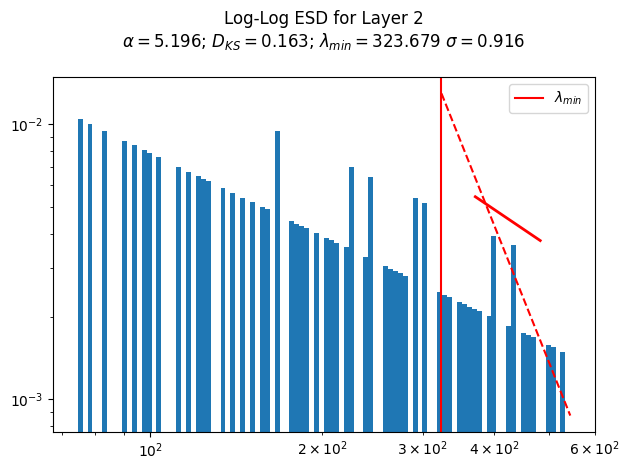

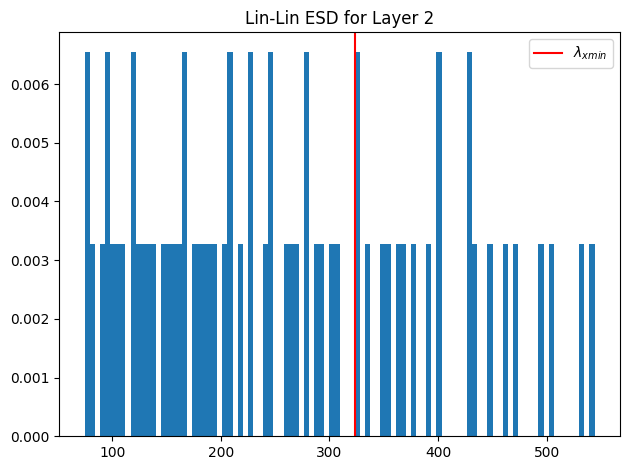

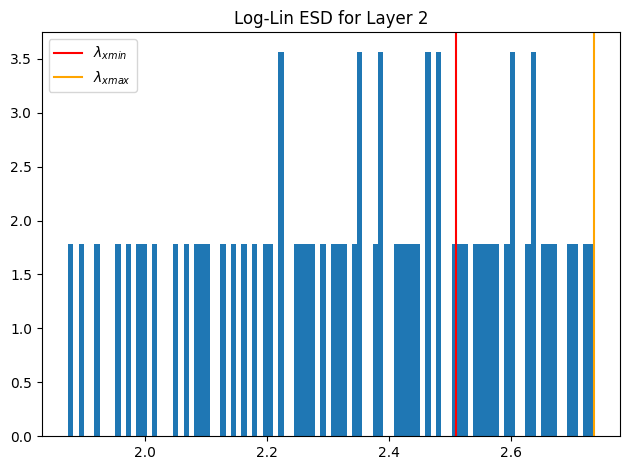

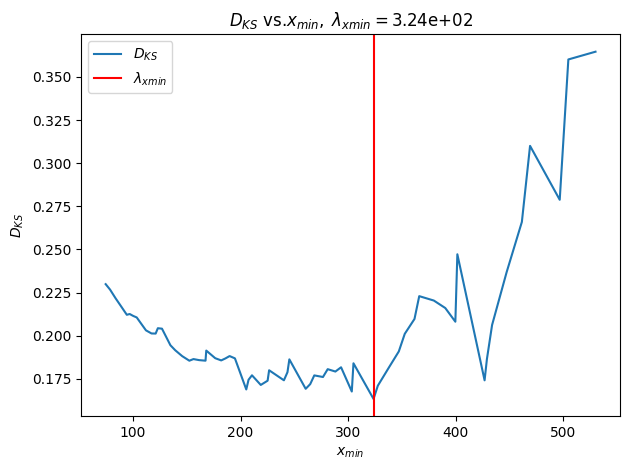

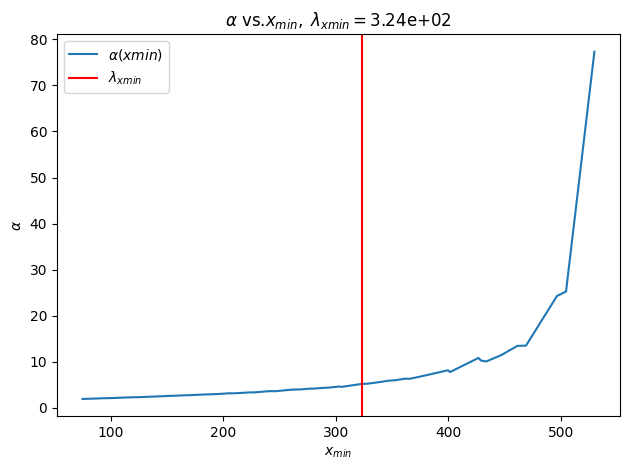

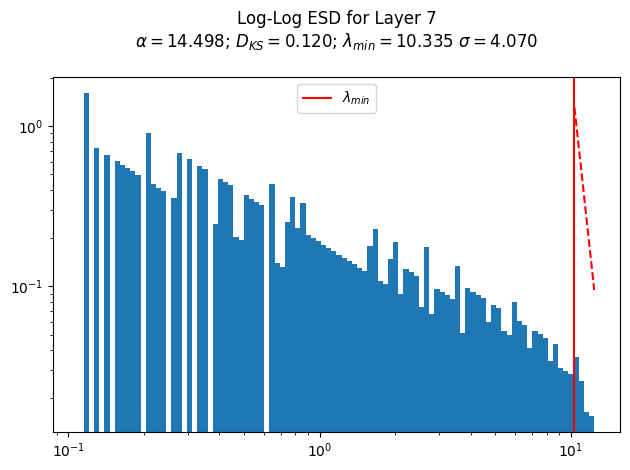

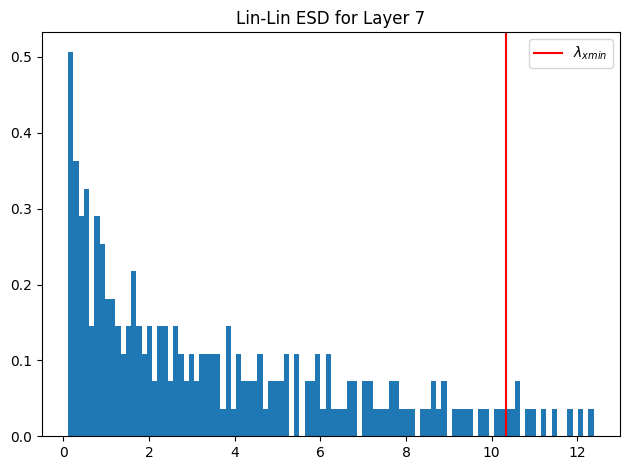

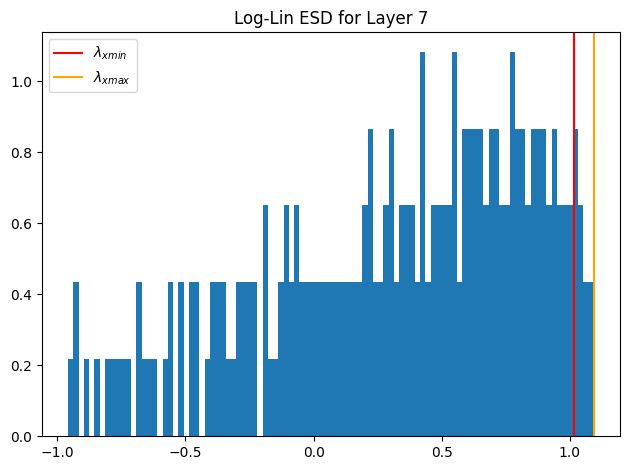

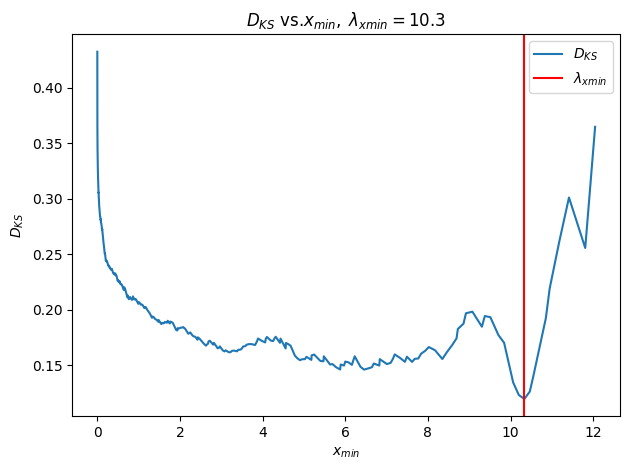

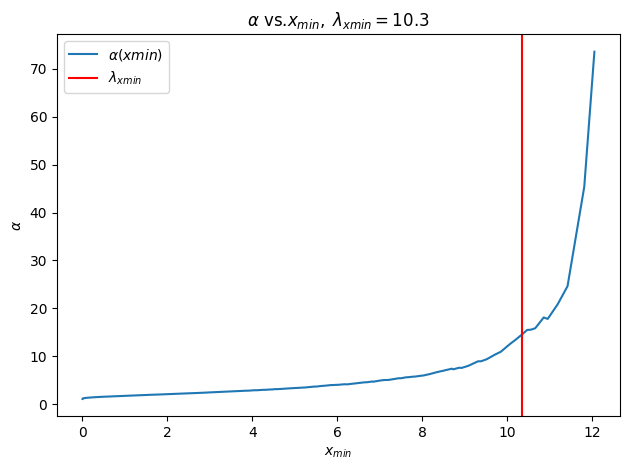

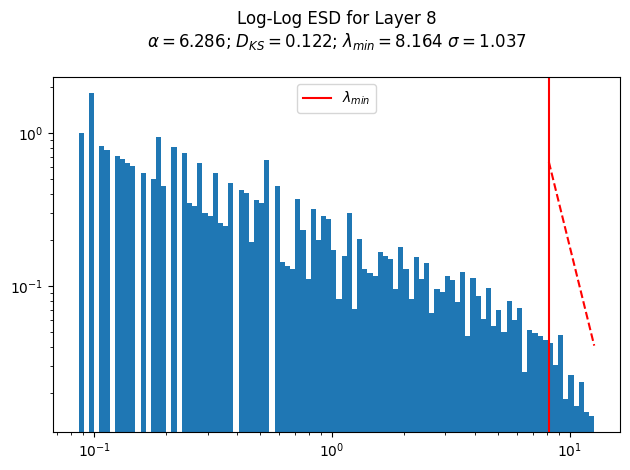

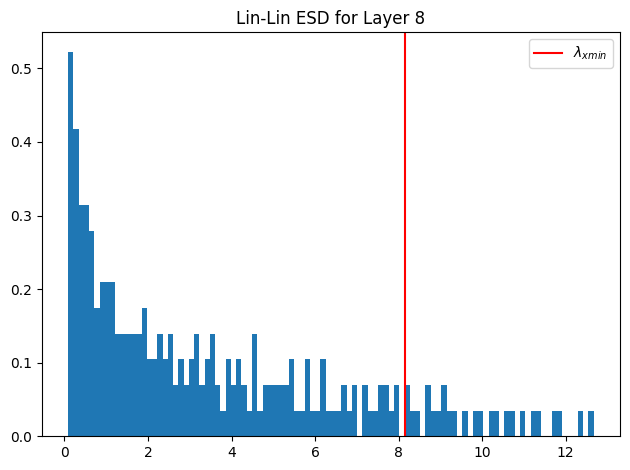

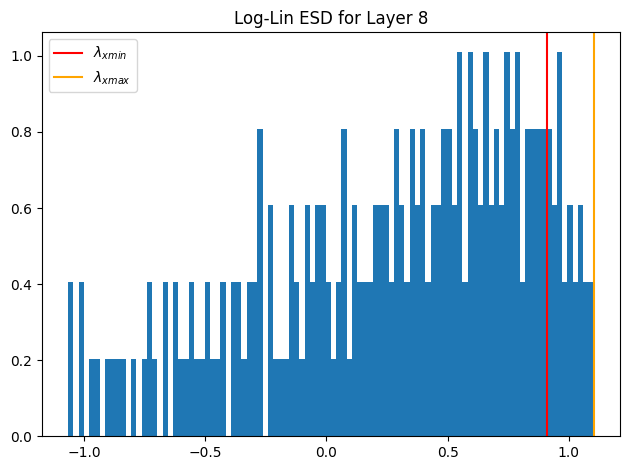

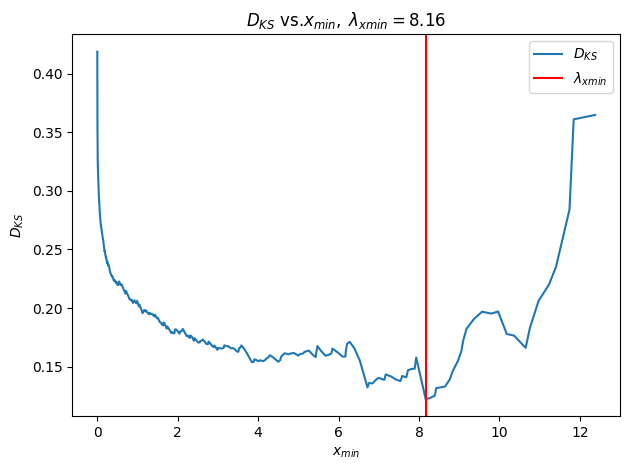

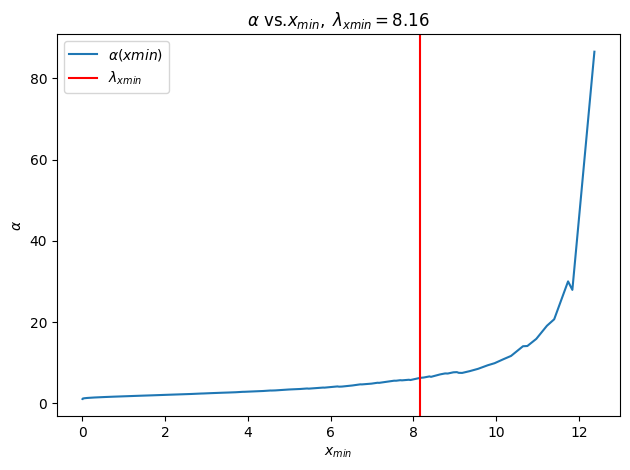

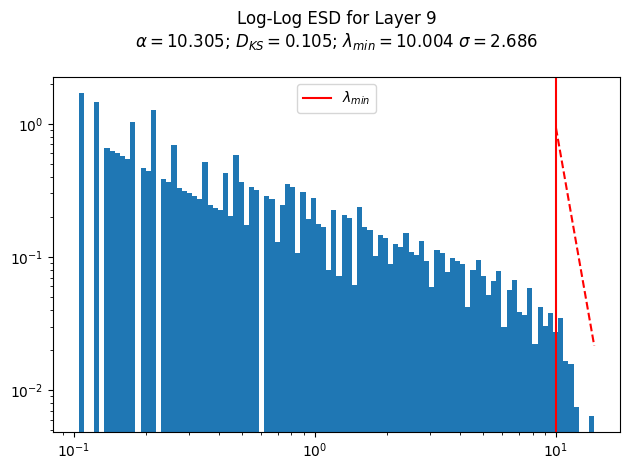

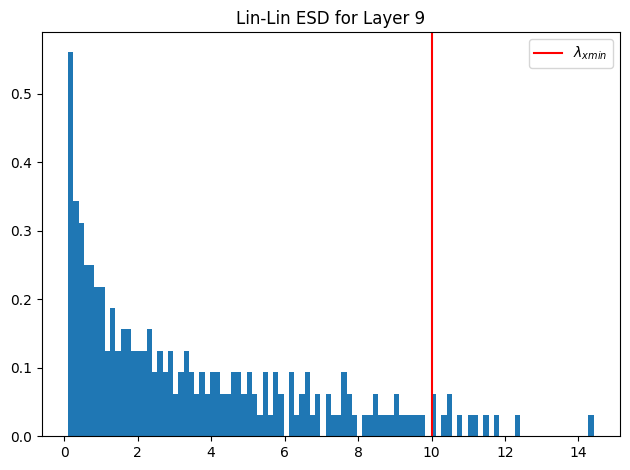

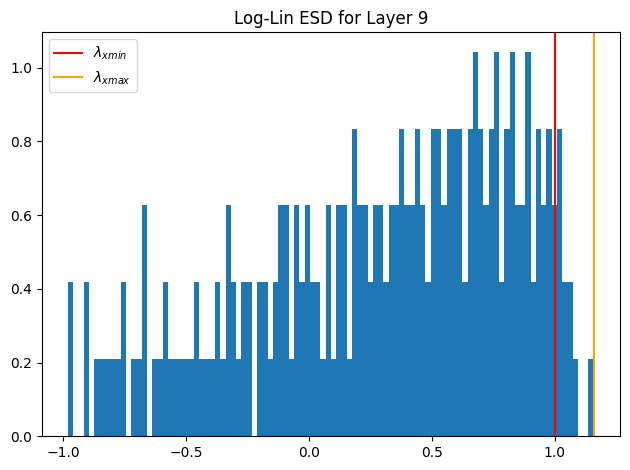

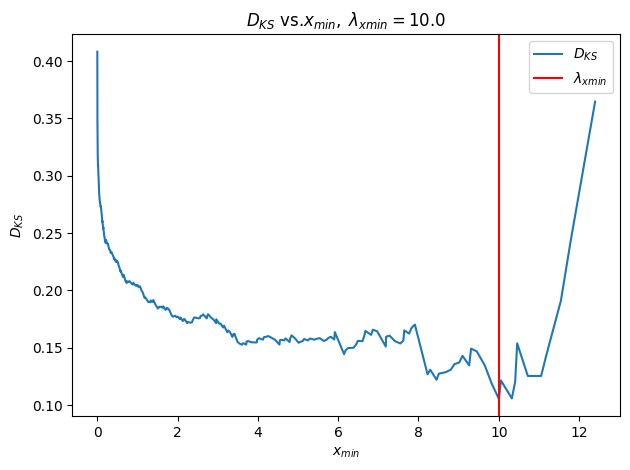

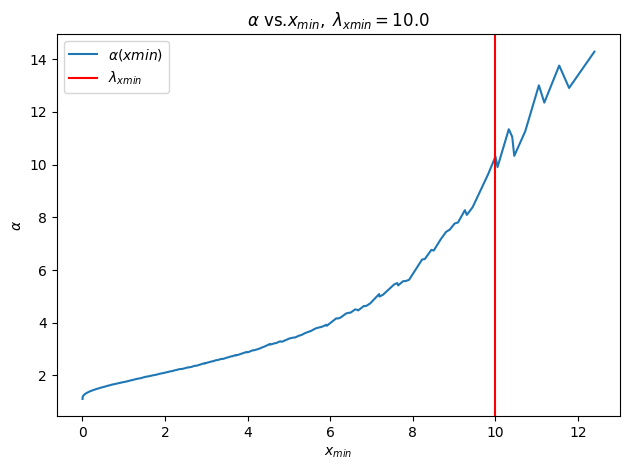

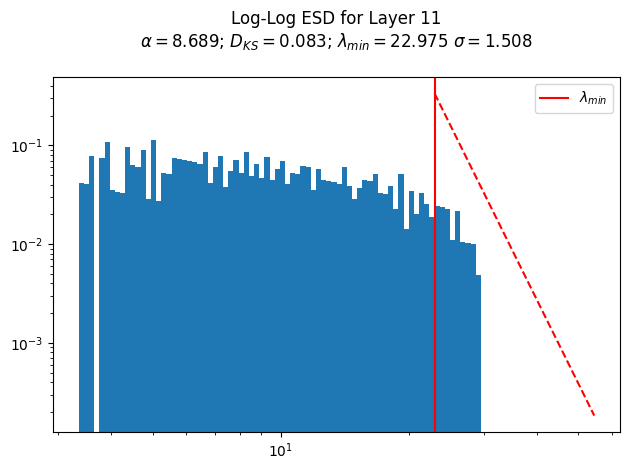

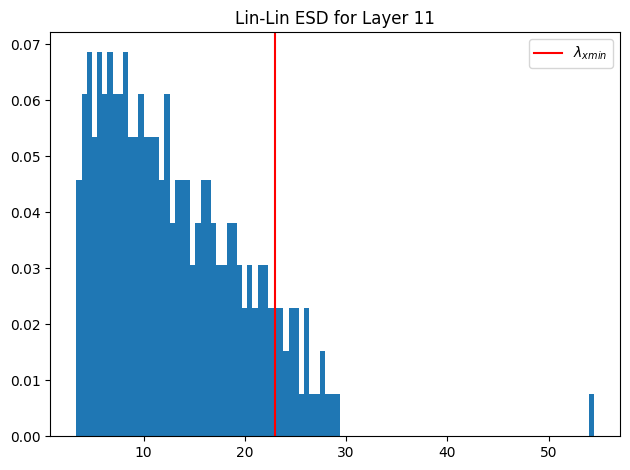

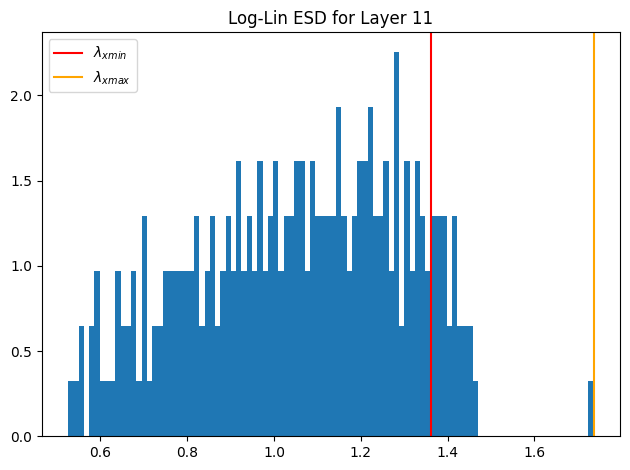

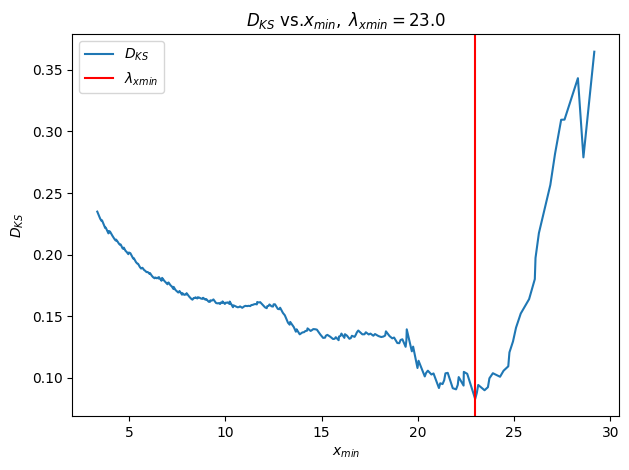

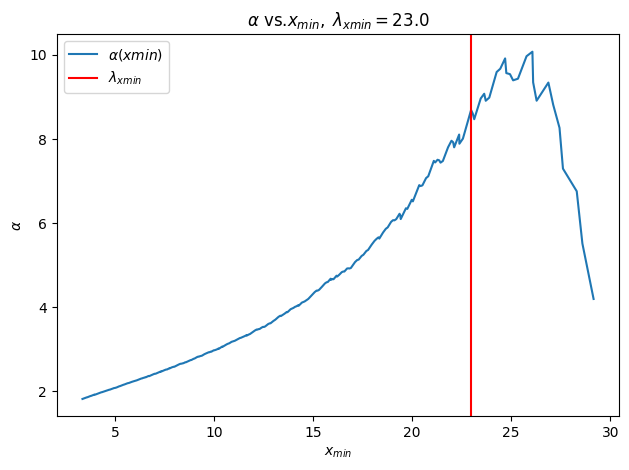

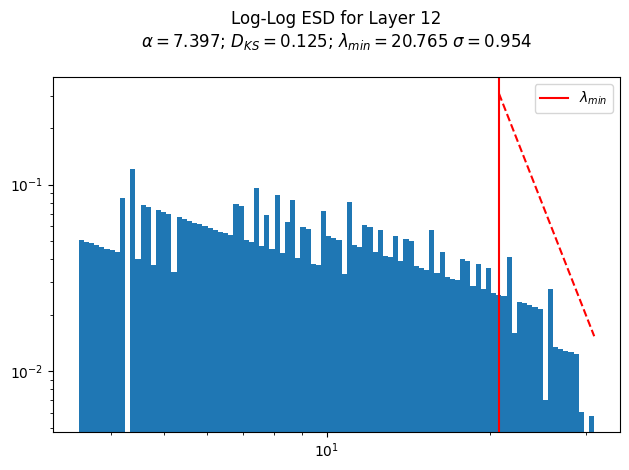

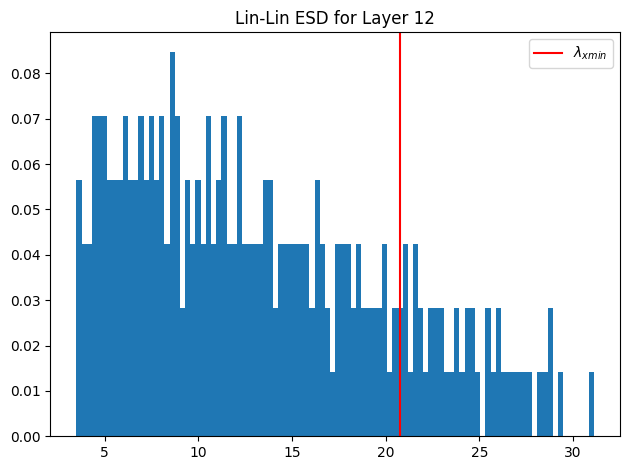

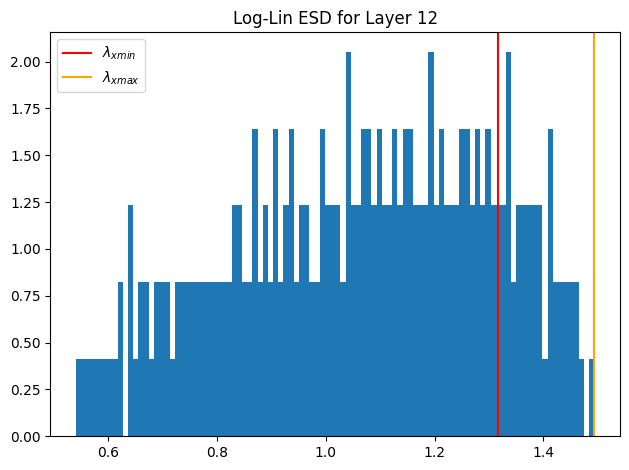

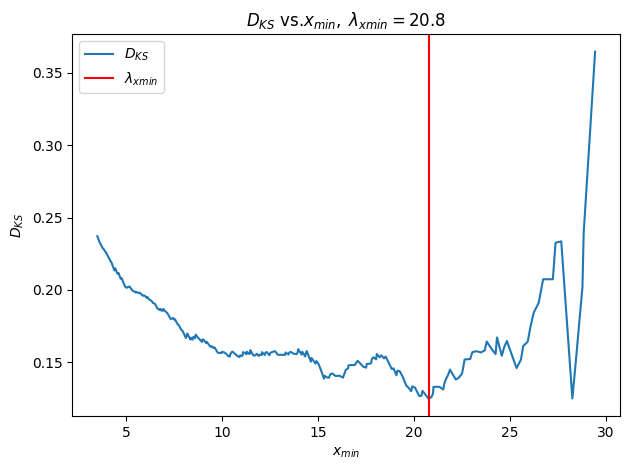

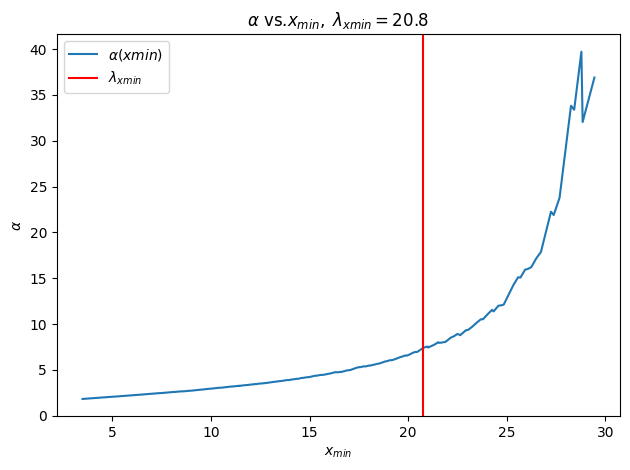

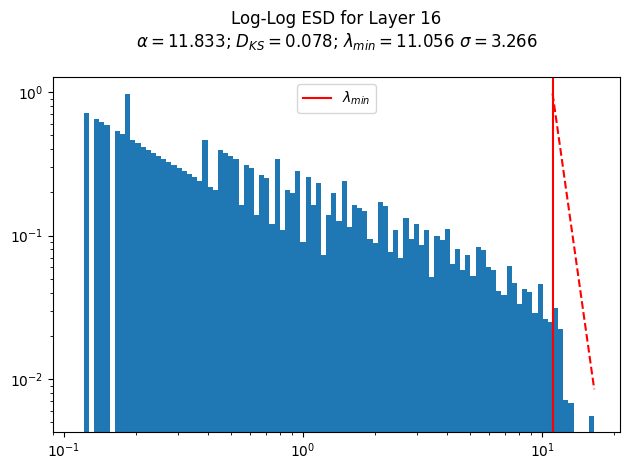

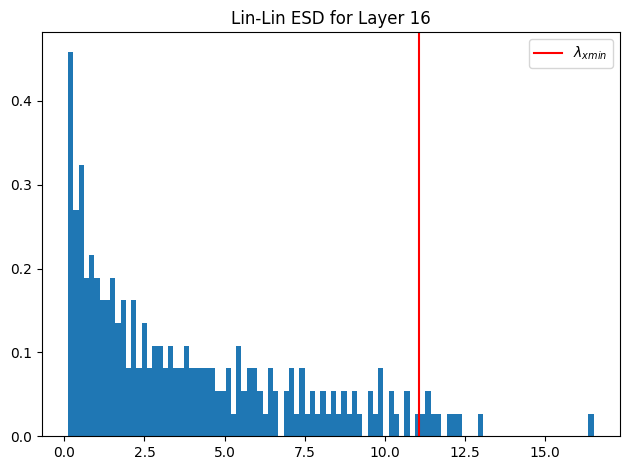

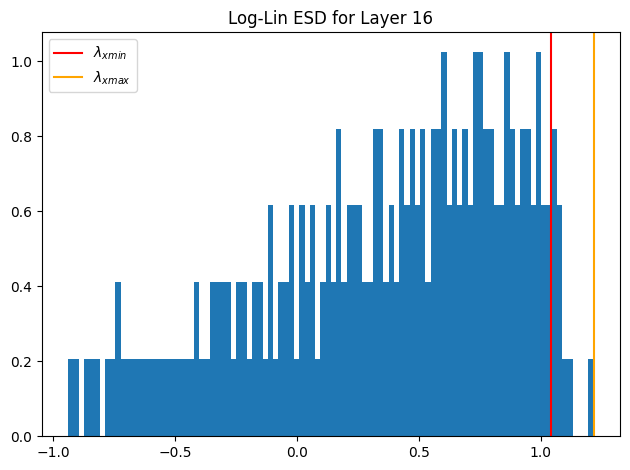

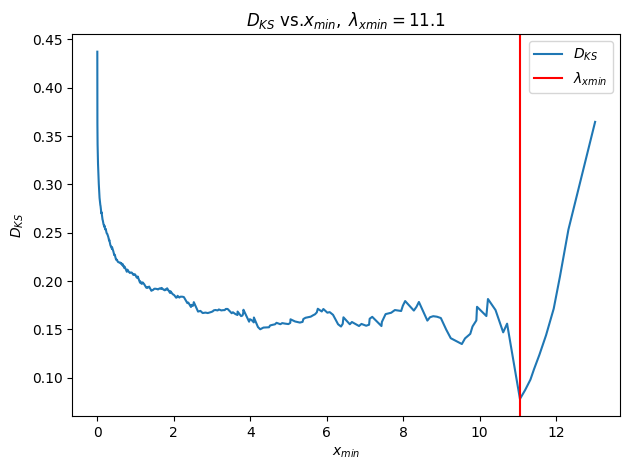

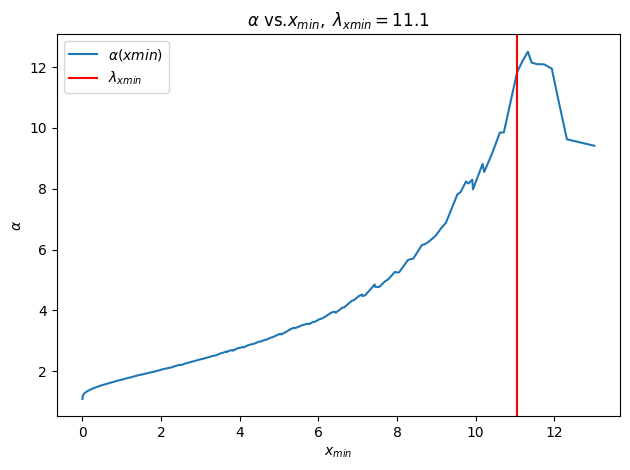

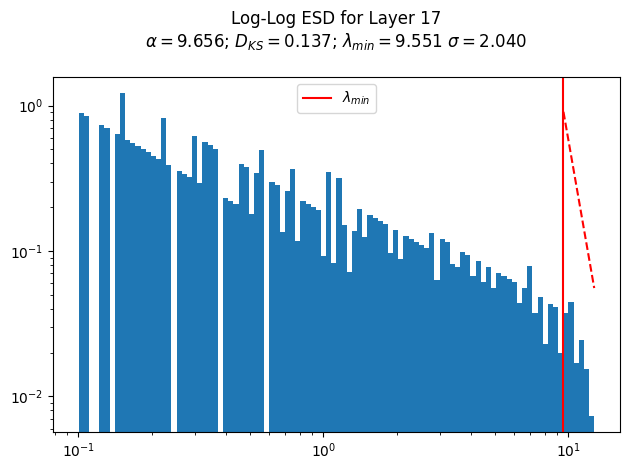

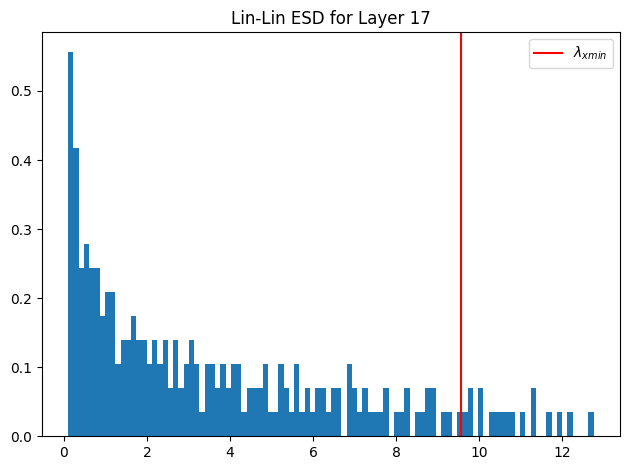

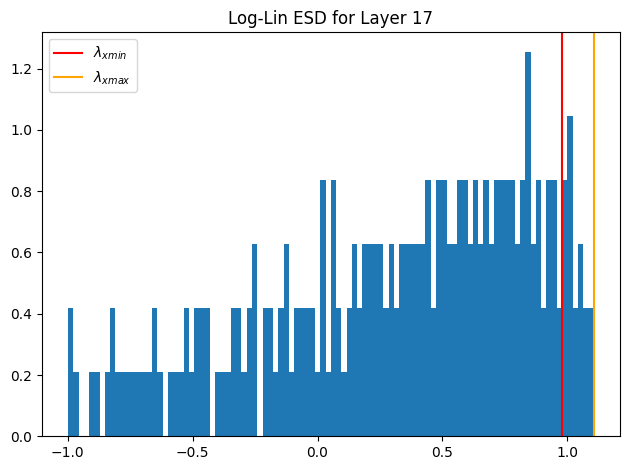

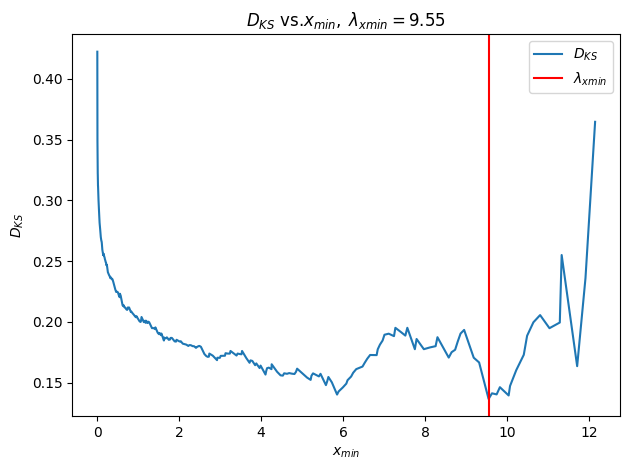

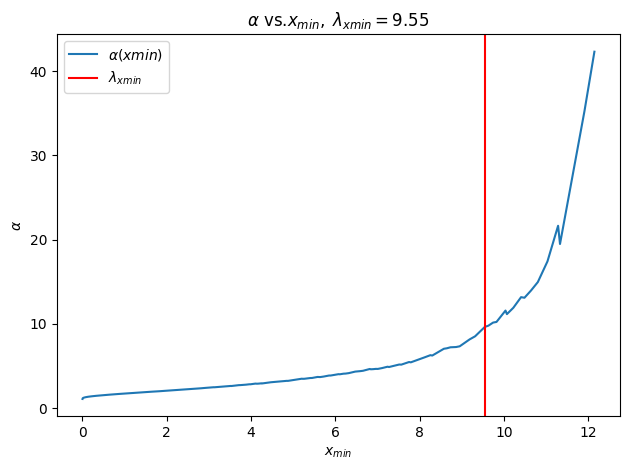

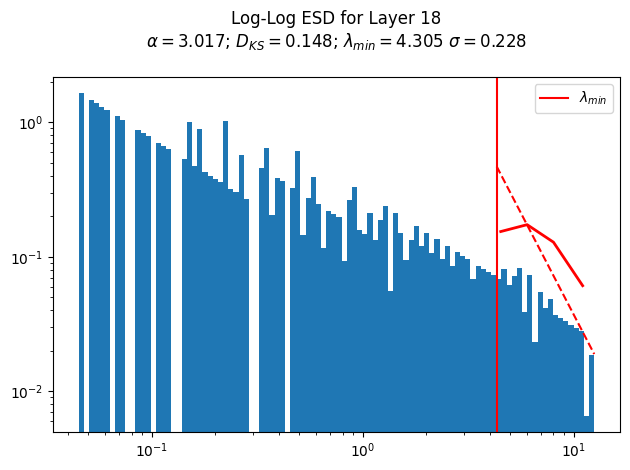

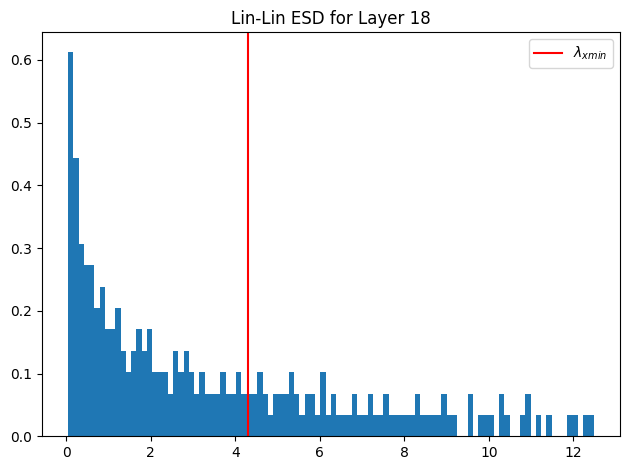

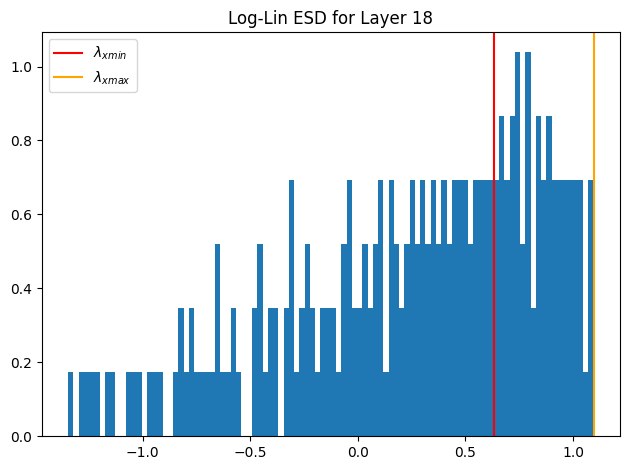

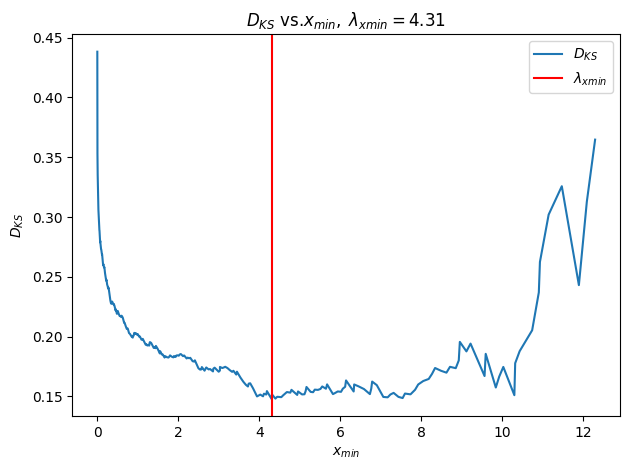

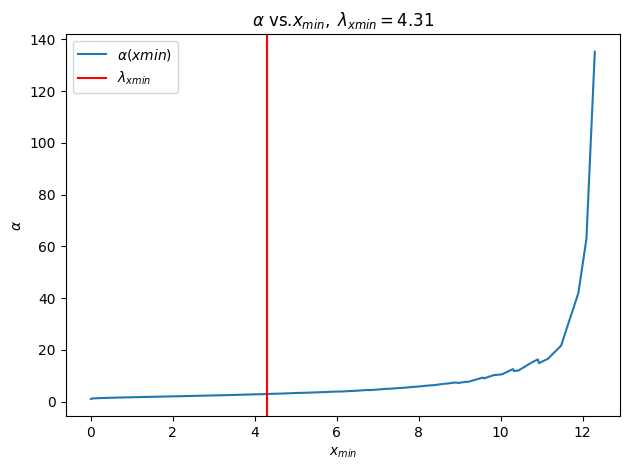

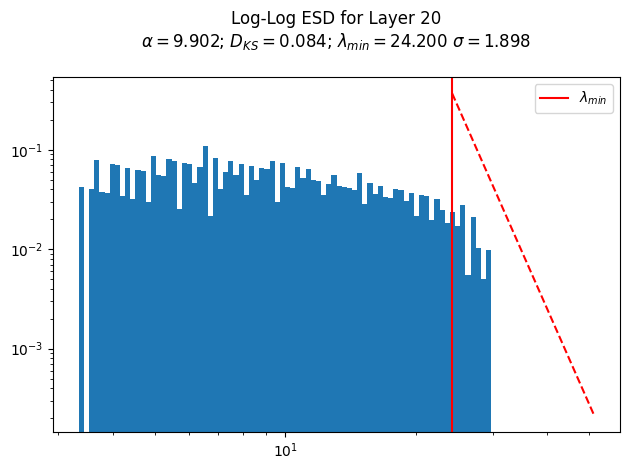

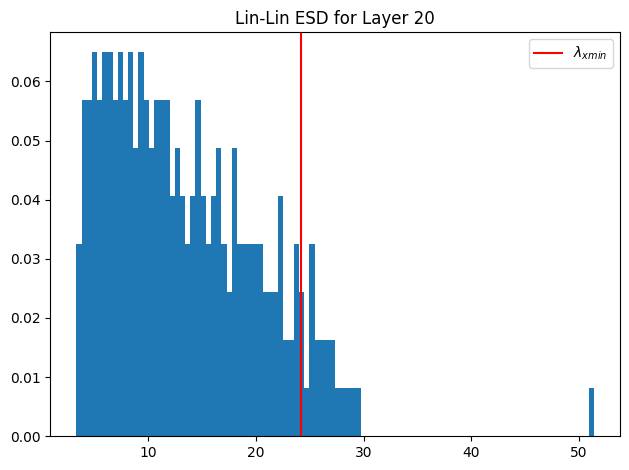

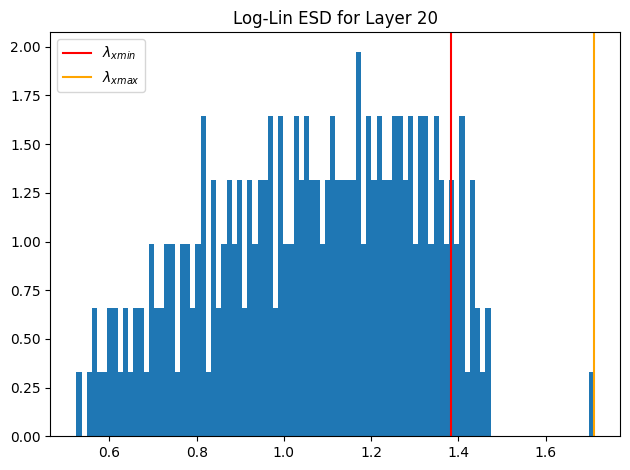

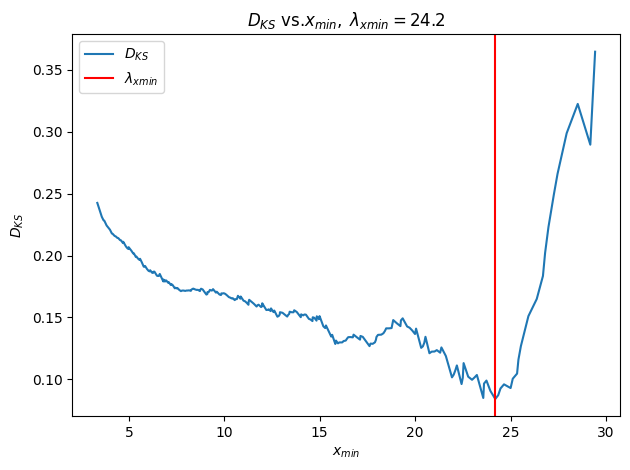

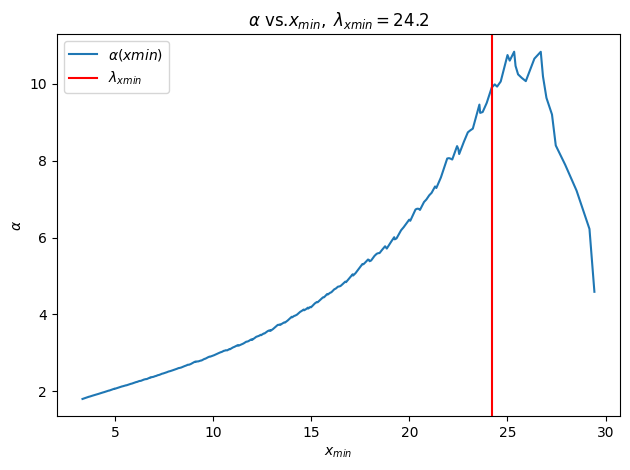

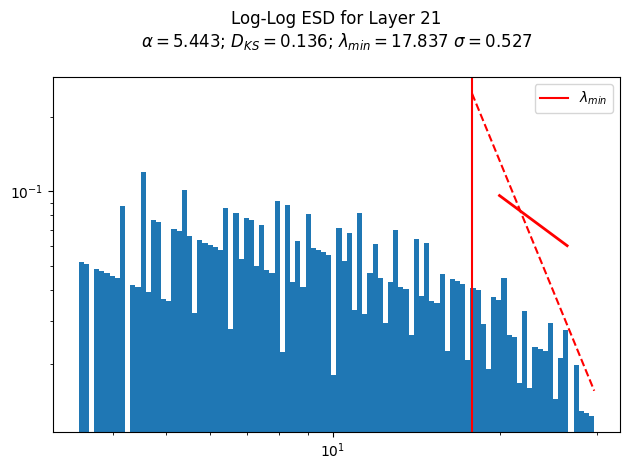

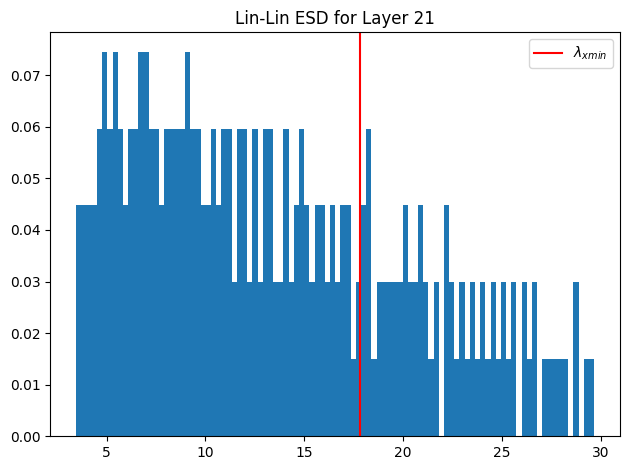

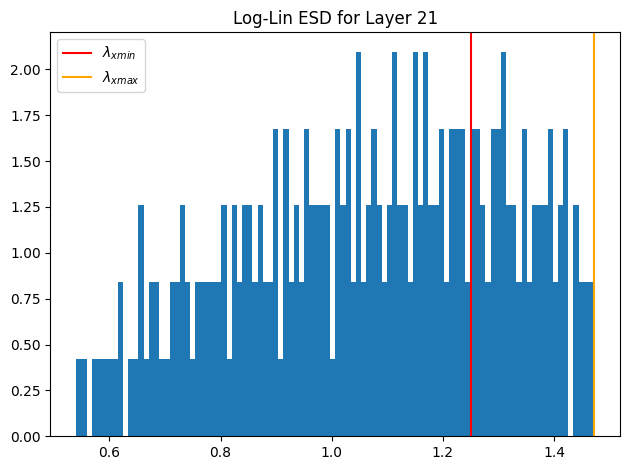

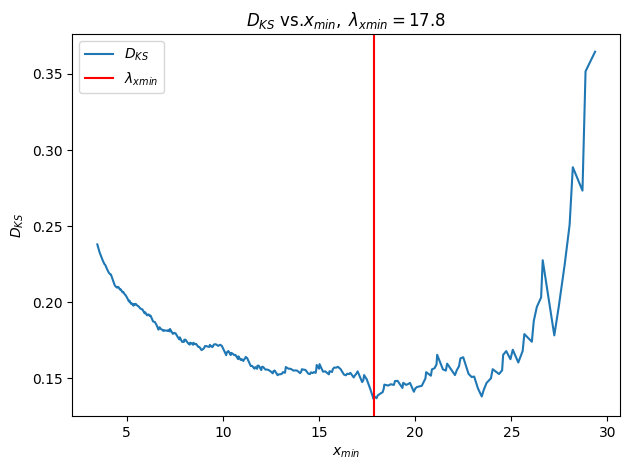

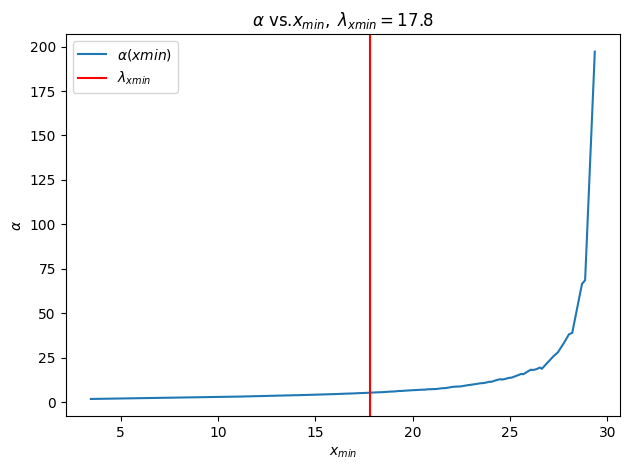

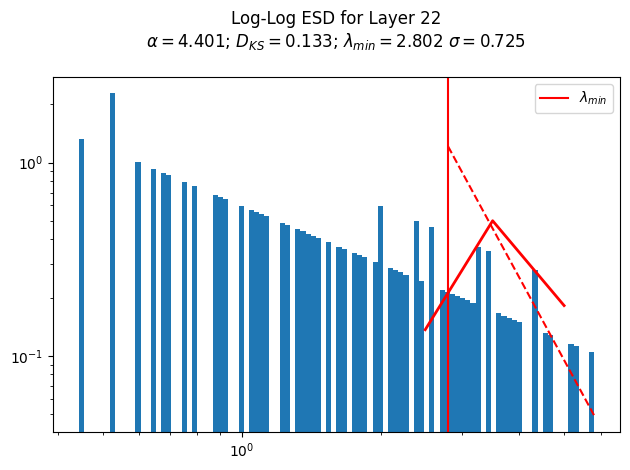

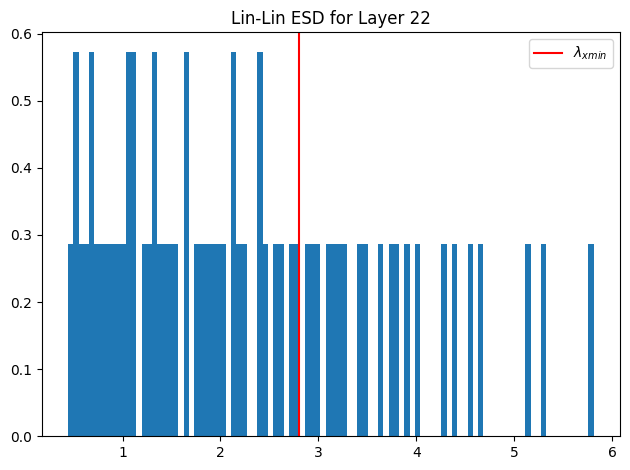

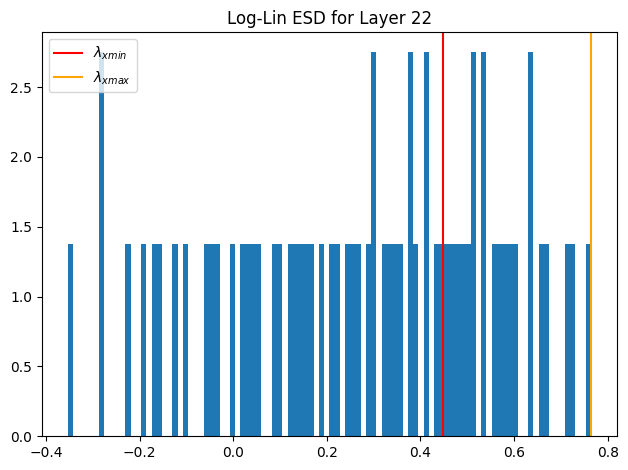

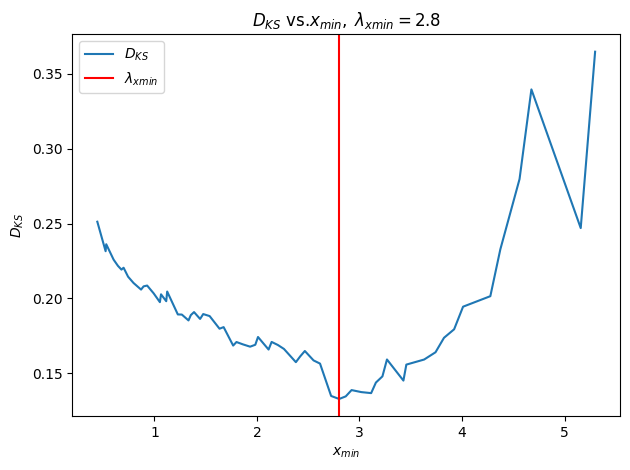

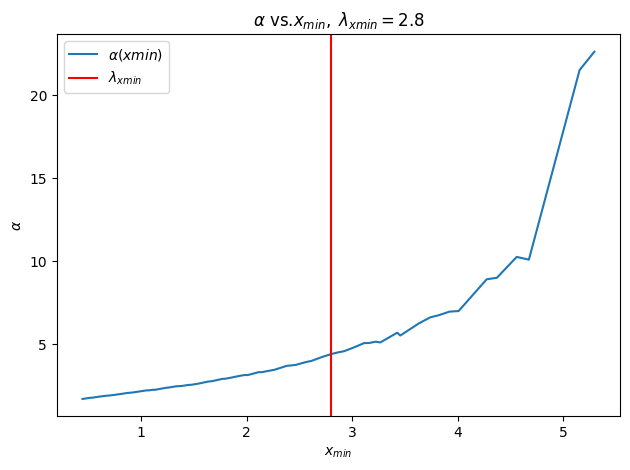

<Figure size 640x480 with 0 Axes>

In [7]:
original_weights = {}

for name, layer in bayesian_model.named_modules():
    if hasattr(layer, 'weight') and hasattr(layer.weight, 'mu'):
        print(f"- 正在处理层: {name}")
        original_weights[name] = layer.weight
        layer.weight = nn.Parameter(layer.weight.mu)
        layer.weight_prior = None
        layer.bias = None
        layer.bias_prior = None

watcher = ww.WeightWatcher(model=bayesian_model)
details = watcher.analyze(plot=True)


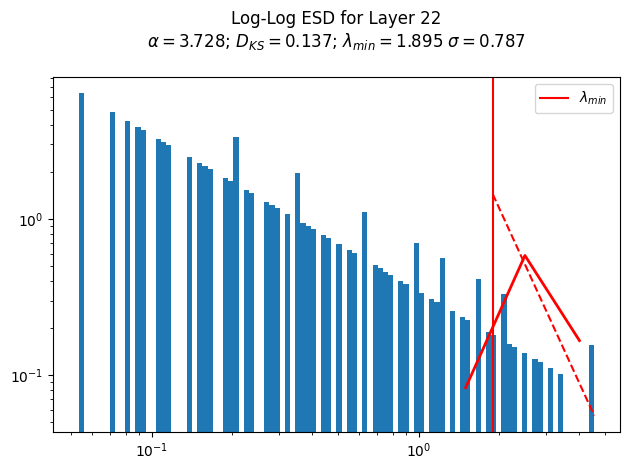

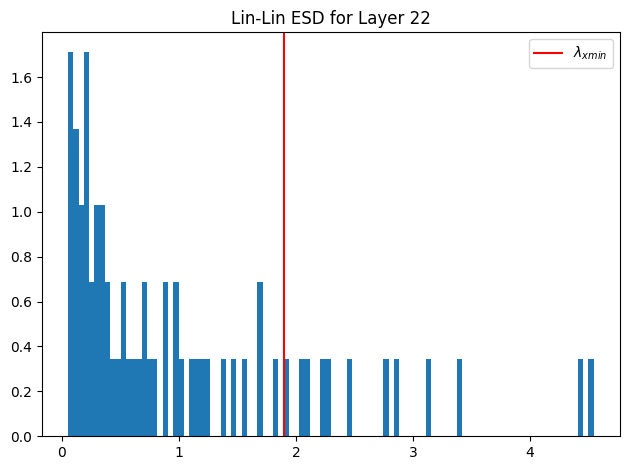

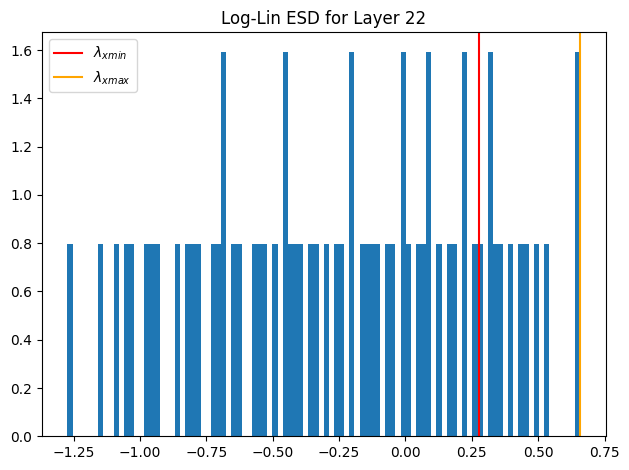

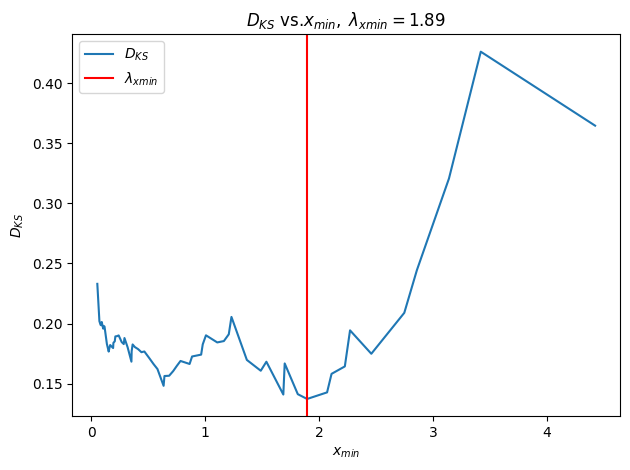

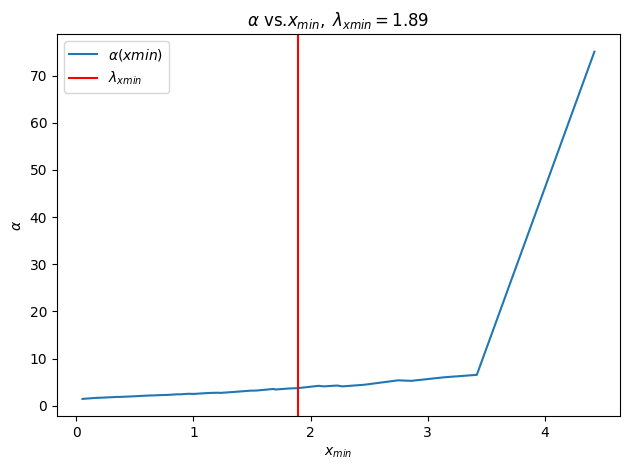

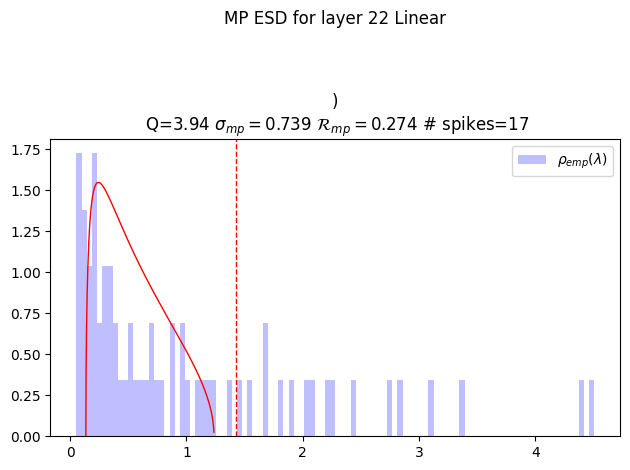

,layer_id,name,D,M,N,Q,W_scale,alpha,alpha_weighted,bulk_max,...,sigma_mp,spectral_norm,stable_rank,status,sv_max,sv_min,warning,weak_rank_loss,xmax,xmin
0,22,Linear\n \n \n \n),0.137216,65,256,3.938462,0.995854,3.72782,2.450493,1.246516,...,0.739313,4.543105,14.426779,success,2.131456,0.231009,,0,4.543105,1.894507


<Figure size 640x480 with 0 Axes>

In [ ]:
watcher.analyze(layers=[22], plot=True, mp_fit=True)

In [ ]:

print(details[['layer_id', 'layer_name', 'num_spikes', 'mp_sigma']])

KeyError: "['layer_name', 'num_spikes', 'mp_sigma'] not in index"

: 